# Lista de Exercícios 5
**Aluno**: Vítor Gabriel Reis Caitité

A base de dados “Apendice V - atributos corrigidos.xlsx” possui 2.540 observações
referentes a características técnicas e ambientais dos conjuntos elétricos
localizados na área de concessão das empresas brasileiras de distribuição de
energia elétrica. Em particular, estamos interessados em modelar o comportamento
médio do indicador DEC (Duração Equivalente de Interrupção por Unidade
Consumidora, expresso em horas e centésimos de hora). Esta informação está
localizada na coluna “DEC_MED” (valores médios considerando o período 2011 a
2013).

Como variáveis explicativas (ou preditoras) devem ser consideradas SOMENTE as
informações disponíveis nas colunas ‘F’ (AREA) até a coluna ‘EH’ (ENE_PNI),
totalizando 133 potenciais variáveis preditoras. As descrições para cada variável
são apresentadas na Nota Técnica n° 102/2014-SRD/ANEEL (em anexo).

O objetivo é ajustar o melhor modelo de regressão para a variável resposta
DEC_MED (Y) a partir das 133 potenciais variáveis preditoras. A análise deve
considerar:

    1) A possibilidade de utilizar a variável resposta transformada, log⁡(y);

    2) Metodologias diferenciadas para a seleção das variáveis preditoras mais
    relevantes;

    3) Diferentes critérios de seleção do modelo final incluindo métodos de
    validação cruzada.

In [34]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from math import *
from scipy import stats
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [2]:
dataset = pd.read_csv('~/Documents/UFMG/Doutorado/materias/Modelos_de_Regressao/atividade_5/dataset.csv', header=0, sep=",", engine='python')
dataset = dataset.dropna()
dataset.head(5)

,COD_U,COD_DIST,DIST,COD_CONJ,CONJ,AREA,AA,ARR,DENS_ARR,DENS_ARR_AA,...,PNI_NUC,ENE_PNI,DEC 11,FEC 11,DEC 12,FEC 12,DEC 13,FEC 13,DEC_MED,FEC_MED
0,1_44213183_Agudo,1,AES SUL,13183,AGUDO,3827.237239,2544.683120,777.413693,0.203127,0.305505,...,3.530664,1.025204,39.43,18.60,24.89,12.33,27.61,12.23,30.643333,14.386667
1,1_44213195_Alegrete,1,AES SUL,13195,ALEGRETE,7021.800116,4611.775143,674.340088,0.096035,0.146221,...,3.439157,1.716243,25.05,11.33,24.24,10.08,34.29,14.81,27.860000,12.073333
2,1_44213230_Cacapava,1,AES SUL,13230,CAÇAPAVA,7702.469144,5776.763972,828.456485,0.107557,0.143412,...,3.141174,1.182324,23.16,9.01,18.12,6.97,18.99,10.65,20.090000,8.876667
3,1_44213206_Cachoeira,1,AES SUL,13206,CACHOEIRA,3695.350590,1134.266436,676.584982,0.183091,0.596496,...,2.337291,1.677759,12.52,7.47,8.97,4.61,8.48,5.25,9.990000,5.776667
4,1_44213217_Campo Bom,1,AES SUL,13217,CAMPO BOM,50.174575,47.975313,318.796425,6.353744,6.645010,...,2.101036,3.080874,9.31,6.87,7.19,4.33,7.46,4.39,7.986667,5.196667


In [3]:
# Selecionando as variáveis de ambiente requeridas:
y = dataset["DEC_MED"]
X = dataset.iloc[:, 5:138]
X.head(5)

,AREA,AA,ARR,DENS_ARR,DENS_ARR_AA,AA_ATEND,AA_NATEND,PC_AA_ATEND,EST_NPAV,EST_PAV,...,TD_ERMT,PNI_URB,PNI_NURB,PC_PNI_NURB,PNI,PNI_AREA,PNI_AA,PNI_ERMT,PNI_NUC,ENE_PNI
0,3827.237239,2544.683120,777.413693,0.203127,0.305505,716.105728,1911.742311,28.1412535273372%,0.0,435.056142,...,1.676352,13044.0,45678.0,77.7868601205681%,58722.0,15.343183,23.076351,30.158931,3.530664,1.025204
1,7021.800116,4611.775143,674.340088,0.096035,0.146221,698.569449,3913.205705,15.1475175551292%,0.0,358.441867,...,0.917511,38871.0,63100.0,61.8803385276206%,101971.0,14.522060,22.111009,32.553762,3.439157,1.716243
2,7702.469144,5776.763972,828.456485,0.107557,0.143412,1010.194267,4801.837142,17.4871999673144%,0.0,556.365564,...,1.193931,27778.5,76486.5,73.3577902460078%,104265.0,13.536568,18.049032,24.976970,3.141174,1.182324
3,3695.350590,1134.266436,676.584982,0.183091,0.596496,239.921054,895.814015,21.152089680975%,0.0,287.298781,...,1.635261,48915.5,25702.5,34.4454421185237%,74618.0,20.192401,65.785249,85.869039,2.337291,1.677759
4,50.174575,47.975313,318.796425,6.353744,6.645010,47.920847,0.054466,99.8864711219562%,0.0,22.902553,...,4.962652,61348.0,1515.0,2.41000270429346%,62863.0,1252.885545,1310.319759,363.174879,2.101036,3.080874


In [4]:
filter_col = [col for col in X if col.startswith('PC')]
for col in filter_col:
    X[col] = X[col].str.rstrip('%').astype(float)/100
X = sm.add_constant(X)

## Modelo de Regressão Linear Múltipla considerando a variável resposta y

In [5]:
model = sm.OLS(y, X)
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                DEC_MED   R-squared:                       0.656
Model:                            OLS   Adj. R-squared:                  0.635
Method:                 Least Squares   F-statistic:                     30.82
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:48:22   Log-Likelihood:                -7198.7
No. Observations:                1856   AIC:                         1.462e+04
Df Residuals:                    1747   BIC:                         1.522e+04
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               75.3389     11.739  

### Remoção de Variáveis do Modelo



Remoção das variáveis  do modelo com P-valor > 0.05. A estratégia utilizada aqui é a Backward Elimination: Começa com todas as variáveis e remove as variáveis com o maior valor de p, uma de cada vez, até que todas as variáveis restantes sejam significativas.


In [6]:
# Iteratively remove variables with p-value > 0.05
while True:
    model = sm.OLS(y, X).fit() 
    p_values = model.pvalues.drop("const")  # Exclude the intercept term
    max_p_value = p_values.max()  # Find the highest p-value

    if max_p_value > 0.05:
        # Drop the variable with the highest p-value
        variable_to_remove = p_values.idxmax()
        X = X.drop(columns=[variable_to_remove])
    else:
        break

# Final model summary
print(model.summary())
print(f"Shape of X: {X.shape}")

                            OLS Regression Results                            
Dep. Variable:                DEC_MED   R-squared:                       0.648
Model:                            OLS   Adj. R-squared:                  0.637
Method:                 Least Squares   F-statistic:                     59.21
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:48:25   Log-Likelihood:                -7218.7
No. Observations:                1856   AIC:                         1.455e+04
Df Residuals:                    1799   BIC:                         1.487e+04
Df Model:                          56                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            76.3291      7.863      9.708

### Avaliação utilizando validação cruzada

In [8]:
# Função para realizar a validação cruzada com OLS
def ols_cross_val_score(X, y, cv=10):
    scores = []
    for train_index, val_index in KFold(n_splits=cv, shuffle=True, random_state=92).split(X):
        X_train_cv, X_val_cv = X.iloc[train_index], X.iloc[val_index]
        y_train_cv, y_val_cv = y.iloc[train_index], y.iloc[val_index]
        
        # Ajustar o modelo OLS
        model = sm.OLS(y_train_cv, X_train_cv)
        result = model.fit()
        
        # Prever e calcular o R² nos dados de validação
        y_pred = result.predict(X_val_cv)
        r2_score = result.rsquared  # R² para o modelo
        scores.append(r2_score)
    
    return np.mean(scores), np.std(scores)
    
cv_r2_mean, cv_r2_std = ols_cross_val_score(X, y)
print(f"R² média +/- desvio padrão (validação cruzada): {round(cv_r2_mean, 4)} +/- {round(cv_r2_std, 4)}")

R² média +/- desvio padrão (validação cruzada): 0.6507 +/- 0.0049


## Modelo de Regressão Linear Múltipla considerando a variável resposta transformada, log⁡(y)

In [9]:
y = dataset["DEC_MED"]
X = dataset.iloc[:, 5:138]
filter_col = [col for col in X if col.startswith('PC')]
for col in filter_col:
    X[col] = X[col].str.rstrip('%').astype(float)/100
X = sm.add_constant(X)
model = sm.OLS(np.log(y), X)
results = model.fit() 
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                DEC_MED   R-squared:                       0.750
Model:                            OLS   Adj. R-squared:                  0.734
Method:                 Least Squares   F-statistic:                     48.46
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:48:26   Log-Likelihood:                -895.66
No. Observations:                1856   AIC:                             2009.
Df Residuals:                    1747   BIC:                             2612.
Df Model:                         108                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.2942      0.393  

### Remoção de Variáveis do Modelo

Remoção das variáveis  do modelo com P-valor > 0.05. A estratégia utilizada aqui é a Backward Elimination: Começa com todas as variáveis e remove as variáveis com o maior valor de p, uma de cada vez, até que todas as variáveis restantes sejam significativas.


In [10]:
# Iteratively remove variables with p-value > 0.05
while True:
    model = sm.OLS(np.log(y), X).fit() 
    p_values = model.pvalues.drop("const")  # Exclude the intercept term
    max_p_value = p_values.max()  # Find the highest p-value

    if max_p_value > 0.05:
        # Drop the variable with the highest p-value
        variable_to_remove = p_values.idxmax()
        X = X.drop(columns=[variable_to_remove])
    else:
        break

# Final model summary
print(model.summary())
print(f"Shape of X: {X.shape}")

                            OLS Regression Results                            
Dep. Variable:                DEC_MED   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.736
Method:                 Least Squares   F-statistic:                     90.02
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        21:48:29   Log-Likelihood:                -916.84
No. Observations:                1856   AIC:                             1952.
Df Residuals:                    1797   BIC:                             2278.
Df Model:                          58                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const             5.5221      0.259     21.342

### Análise do modelo

#### Actual vs. Predicted Values



Este gráfico ajuda a visualizar o quão bem as previsões do modelo se alinham com os valores reais.

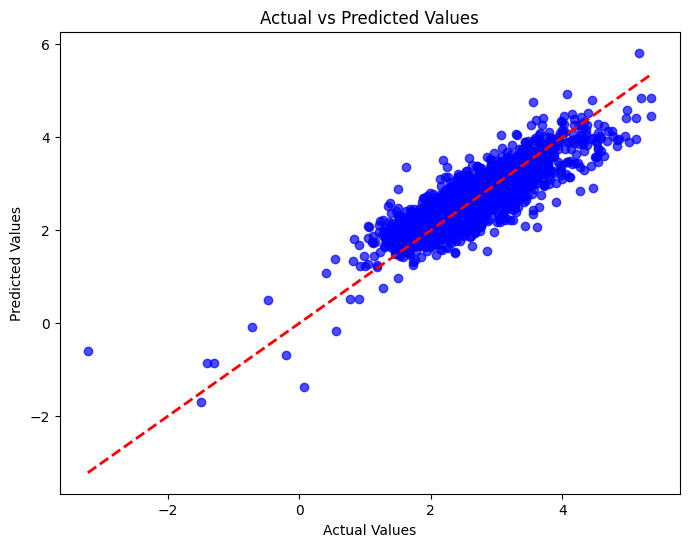

In [11]:
# Predictions
y_pred = model.predict(X)

# Plot actual vs. predicted
plt.figure(figsize=(8, 6))
plt.scatter(np.log(y), y_pred, alpha=0.7, color="blue")
plt.plot([np.log(y).min(), np.log(y).max()], [np.log(y).min(), np.log(y).max()], color="red", linestyle="--", linewidth=2)
plt.title("Actual vs Predicted Values")
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.show()


#### Coefficient Importance (Feature Weights)



A intenção do plot abaixo é observar a importância de cada coeficiente do nosso modelo. Ele exibe os coeficientes associados às variáveis preditoras ($Xi$) do modelo, indicando sua contribuição relativa para o resultado ($y$).

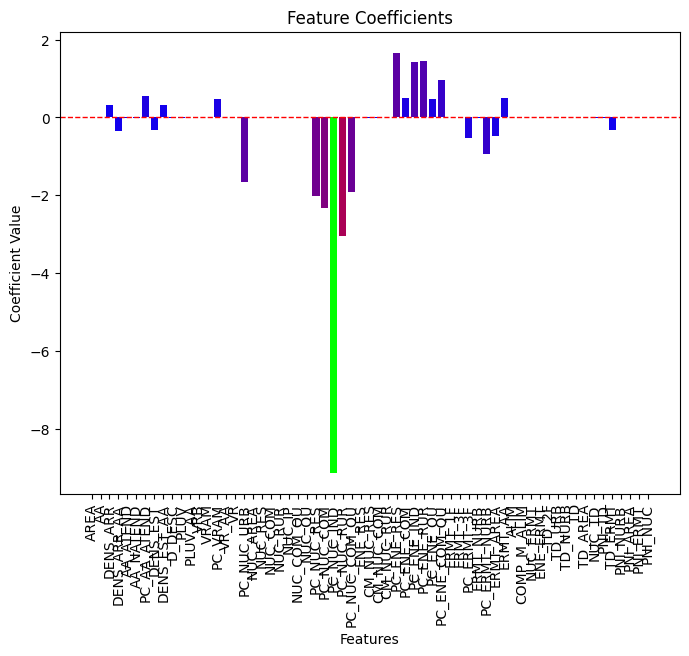

In [12]:
coefficients = model.params[1:]  # Exclude the intercept
features = X.columns[1:]  # Exclude the constant term

# Define colors based on magnitude
colors = coefficients.abs()  
colors = colors/colors.max()  

# Plot coefficients
plt.figure(figsize=(8, 6))
bars = plt.bar(features, coefficients, color=plt.cm.brg(colors))
plt.axhline(0, color="red", linestyle="--", linewidth=1)
plt.title("Feature Coefficients")
plt.xlabel("Features")
plt.ylabel("Coefficient Value")
plt.xticks(rotation=90)
plt.show()

#### Gráfico quantil-quantil



Esse gráfico busca comparar duas distribuições de probabilidade, traçando seus quantis uns contra os outros. e as duas distribuições que estão sendo comparadas são semelhantes, os pontos no gráfico Q-Q vão repousar aproximadamente na linha y = x. O gráfico q-q pode ser usado para verificar se os resíduos apresentam distribuição normal. 

Quando os pontos de um QQ plot caem sobre a linha de 45º, isso significa que os dados observados seguem aproximadamente a distribuição de referência.

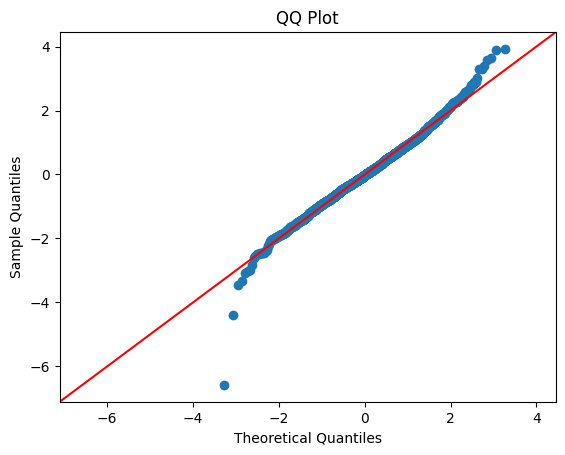

In [13]:
# QQ plot
residuals = np.log(y) - y_pred
sm.qqplot(residuals, line='45', fit=True)
plt.title("QQ Plot")
plt.show()

Observando o gráfico acima podemos inferir que os resíduos do modelo são aproximadamente normais, o que é uma suposição fundamental da regressão linear.

#### Avaliação utilizando validação cruzada

In [14]:
cv_r2_mean, cv_r2_std = ols_cross_val_score(X, np.log(y))
print(f"R² média +/- desvio padrão (validação cruzada): {round(cv_r2_mean, 4)} +/- {round(cv_r2_std, 4)}")

R² média +/- desvio padrão (validação cruzada): 0.7453 +/- 0.0032


Os modelos com $y$ e $log⁡(y)$ têm escalas diferentes, e a transformação logarítmica pode alterar substancialmente a dispersão dos dados, afetando diretamente a medida de $R^2$. Em $OLS(log⁡(y),X)$, os coeficientes representam elasticidades (mudança percentual em $y$ para uma mudança unitária em $X$), enquanto em $OLS(y,X)$, os coeficientes representam mudanças absolutas em $y$ para uma mudança unitária em $X$. Portanto, os $R^2$ não representam a mesma coisa.

## Seleção de Variáveis utilizando o PCA e Validação Cruzada

Nesta etapa os seguintes passos serão realizados:

    1. Pré-processamento dos dados. O PCA é sensível às escalas das variáveis, portanto a padronização é necessária.
    2. Reduzir a dimensionalidade dos dados utilizando PCA.
    3. Treinar um modelo de regressão linear: Usar os componentes principais como variáveis de entrada no modelo de regressão.


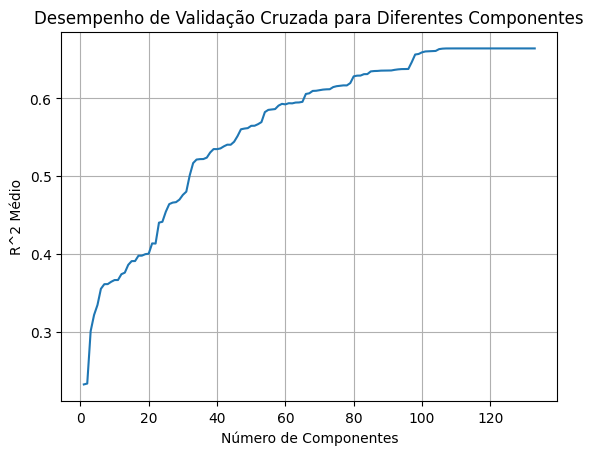

Número ideal de componentes (baseado no R^2): 108


In [15]:
y = pd.DataFrame(dataset["DEC_MED"].to_numpy().reshape(-1))
X = dataset.iloc[:, 5:138]
filter_col = [col for col in X if col.startswith('PC')]
for col in filter_col:
    X[col] = X[col].str.rstrip('%').astype(float)/100

# Pré-processamento:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Validando com diferentes números de componentes
scores = []
for n in range(1, X_scaled.shape[1]+1):
    pca = PCA(n_components=n)
    X_pca = pd.DataFrame(pca.fit_transform(X_scaled))
    X_pca = sm.add_constant(X_pca)
    score, _ = ols_cross_val_score(X_pca, y, cv=5)
    scores.append(np.mean(score))

# Visualizando a escolha do número de componentes com base no desempenho
plt.plot(range(1, X_scaled.shape[1]+1), scores)
plt.title('Desempenho de Validação Cruzada para Diferentes Componentes')
plt.xlabel('Número de Componentes')
plt.ylabel('R^2 Médio')
plt.grid(True)
plt.show()

# Número de componentes que minimiza o MSE
optimal_n_components = np.argmax(scores) + 1
print(f"Número ideal de componentes (baseado no R^2): {optimal_n_components}")


## Remoção de Multicolinearidade com VIF

O objetivo agora é identificar e excluir variáveis preditoras que estão fortemente correlacionadas com outras variáveis no conjunto de dados. A multicolinearidade pode ser identificada usando métricas como o Fator de Inflação da Variância (VIF) ou a matriz de correlação. A estratégia aqui será remover todas as variáveis que possuírem VIF maior que 10. Sendo:

$$VIF_i = \frac{1}{1-R_i^2}$$


In [38]:
# Função responsável por calcular o VIF para cada coluna do DataFrame X:
def calculate_vif(X):
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    with np.errstate(divide='ignore'):
        vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif_data

# Função responsável por remover colunas com VIF maior que o limite especificado (threshold):
def remove_multicollinearity(X, threshold=10):
    while True:
        # Calcular VIF
        vif_data = calculate_vif(X)
        max_vif = vif_data["VIF"].max()
        
        if max_vif > threshold:
            # Remover a variável com o maior VIF
            drop_feature = vif_data.loc[vif_data["VIF"].idxmax(), "feature"]
            print(f"Removendo '{drop_feature}' com VIF = {max_vif:.2f}")
            X = X.drop(columns=[drop_feature])
        else:
            break
    return X

In [39]:
y = dataset["DEC_MED"]
X = dataset.iloc[:, 5:138]
filter_col = [col for col in X if col.startswith('PC')]
for col in filter_col:
    X[col] = X[col].str.rstrip('%').astype(float)/100

X = remove_multicollinearity(X, threshold=10)

Removendo 'EST_NPAV' com VIF = inf
Removendo 'DENS_EST_NPAV' com VIF = inf
Removendo 'DENS_EST_NPAV_AA' com VIF = inf
Removendo 'VRA_AA' com VIF = inf
Removendo 'PC_VRA_AA' com VIF = inf
Removendo 'VRA' com VIF = inf
Removendo 'PC_VRA' com VIF = inf
Removendo 'VRB_AA' com VIF = inf
Removendo 'PC_VRB_AA' com VIF = inf
Removendo 'VRB' com VIF = inf
Removendo 'PC_VRB' com VIF = inf
Removendo 'NUC_URB' com VIF = inf
Removendo 'NUC_COM' com VIF = inf
Removendo 'NUC_PP' com VIF = inf
Removendo 'PC_NUC_COM' com VIF = inf
Removendo 'ENE_RES' com VIF = inf
Removendo 'ENE_COM' com VIF = inf
Removendo 'PC_ENE_COM' com VIF = inf
Removendo 'ERMT_1F' com VIF = inf
Removendo 'ERMT_URB' com VIF = inf
Removendo 'TD_1F' com VIF = inf
Removendo 'PNI_1F' com VIF = inf
Removendo 'TD_URB' com VIF = inf
Removendo 'PNI_URB' com VIF = inf
Removendo 'PNI_AA' com VIF = 112570.09
Removendo 'TD_AA' com VIF = 34090.99
Removendo 'DENS_EST' com VIF = 25185.60
Removendo 'DENS_EST_AA' com VIF = 13232.40
Removendo 'EST'

In [44]:
cv_r2_mean, cv_r2_std = ols_cross_val_score(X, y)
print(f"R² média +/- desvio padrão (validação cruzada): {round(cv_r2_mean, 4)} +/- {round(cv_r2_std, 4)}")

R² média +/- desvio padrão (validação cruzada): 0.7374 +/- 0.0031


In [45]:
cv_r2_mean, cv_r2_std = ols_cross_val_score(X, np.log(y))
print(f"R² média +/- desvio padrão (validação cruzada): {round(cv_r2_mean, 4)} +/- {round(cv_r2_std, 4)}")

R² média +/- desvio padrão (validação cruzada): 0.9493 +/- 0.0011
